In [1]:
#ignore warnings for clear printing
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import seaborn as sns # More snazzy plotting library
import itertools


##test results 
#  1.looks the absolute year number gives a good colleration for prediction. 
#  2. standarlistaion improves prediction by 3%
#  3. removing aspect ratio improves prediction by 2%


#open the file
file_path = "/home/user/projects/data_mining/predictive_data_mining/logistic_regression/working_dataset.csv"
dta = pd.read_csv(file_path)
#clean up data non numeric rows
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in dta.iteritems():
    if type(colvalue[1]) == str:
        #if colname not in str_list:
            str_list.append(colname)
# Get to the numeric columns by inversion
num_list = dta.columns.difference(str_list)
#USe only the numeriv values
dta_clean = dta[num_list]
#remove the null values, that is fill NaN with there - FIXME: Rihards, naive implementation
#dta_clean = dta_clean.fillna(value=0, axis=1)
dta_clean = dta_clean.dropna()
dta_clean = dta_clean.reindex_axis(sorted(dta_clean.columns), axis=1)
#clean up data from zero rows 
for colname, colvalue in dta_clean.iteritems():
    if colname != 'facenumber_in_poster':
        dta_clean = dta_clean[dta_clean[colname] != 0]
dta_clean.count()
#clasify the data for the logistic regression
def label_gross (gross):
    if (gross < 1000000) : return 1
    elif ((gross >= 1000000) & (gross < 10000000)) : return 2
    elif ((gross >= 10000000) & (gross < 50000000)) : return 3
    elif ((gross >= 50000000) & (gross < 200000000)) : return 4
    elif (gross >= 200000000) : return 5

dta_clean['gross_class'] = dta_clean.gross.apply (lambda gross: label_gross (gross))
dta_clean.count()

#define regression function
def run_logistic_regression(yIn, xIn, solver, prct_split=0.3, scale=False, stadartlize=False, normalize=False, print_intr=False):
        #flatten the y vector
        yIn = np.ravel(yIn)
        
        #do data tranformation
        if scale: 
            min_max_scaler = preprocessing.MinMaxScaler()
            for colname, colvalue in xIn.iteritems():
                xIn[colname] = min_max_scaler.fit_transform(xIn[colname])
        
        if stadartlize:             
            for colname, colvalue in xIn.iteritems():
                standard_scaler = preprocessing.StandardScaler().fit(xIn[colname])
                xIn[colname] = standard_scaler.transform(xIn[colname])

        if normalize: 
            for colname, colvalue in xIn.iteritems():
                nomalizer_scaler = preprocessing.Normalizer().fit(xIn[colname])
                xIn[colname] = nomalizer_scaler.transform(xIn[colname])[0] 
                
        #train the model
        X_train, X_test, y_train, y_test = train_test_split(xIn, yIn, test_size=prct_split, random_state=0)
        model = LogisticRegression(solver=solver)
        model.fit(X_train, y_train)
        
        # predict class labels for the test set
        predicted = model.predict(X_test)
        
        # find the avarge score 10 iterations
        scores = cross_val_score(model, xIn, yIn, scoring='accuracy', cv=10)
       
        #print findings
        if print_intr: 
            print "Running with scale: " + str(scale) + ", stadartlize: " + str(stadartlize) + ", normalize: " + str(normalize)
            print "Test data acuracy is: " + str(metrics.accuracy_score(y_test,predicted))
            print  "Avarage model score: " + str(scores.mean())
        
        return metrics.accuracy_score(y_test,predicted), scores.mean()

#define data trasormation itterator
def run_logc_reg_with_data_trasn(yIn,xIn,prct_split, print_intr):
    prev_test_acc = 0
    prev_avg_acc = 0 
    test_acc_str = "No Result"
    avg_ac_str = "No Result"
    for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag']:
        if print_intr:
            print "######################################################"
            print "Starting regressions sequance with solver: " + solver
        for scale in [False, True]: 
            for stadartlize in [False, True]:
                for normalize in [False, True]:
                    test_acc, avg_acc = run_logistic_regression(yIn,xIn,solver, prct_split, scale, stadartlize, normalize, print_intr)
                    #save the highest accuracy result and result string
                    if test_acc > prev_test_acc: 
                        prev_test_acc = test_acc
                        test_acc_str = "End highest test acc " + str(test_acc) + ", achieved with solver: " + solver + ", scale: " + str(scale) + ", stadartlize: " + str(stadartlize) + ", normalize: " + str(normalize)
                    if avg_acc  > prev_avg_acc :
                        prev_avg_acc = avg_acc              
                        avg_ac_str = "End highest avg model acc " + str(avg_acc) + ", achieved with solver: " + solver + ", scale: " + str(scale) + ", stadartlize: " + str(stadartlize) + ", normalize: " + str(normalize)
        if print_intr: print "######################################################"
    print test_acc_str
    print avg_ac_str
    return prev_test_acc, prev_avg_acc

def run_diff_predictors():
    headers = list(dta_clean.columns.values)
    headers.remove('gross_class')
    headers.remove('gross')
    itter = 0
    prev_test_acc = 0
    prev_avg_acc = 0
    best_test_acc_str = "No results"
    best_avg_acc_str = "No results"
    iterator = 0
    for L in range(0, len(headers)+1):
        for subset in itertools.combinations(headers, L):
            iterator = iterator + 1
    print "Running total " + str(iterator) + " itterators"
    for L in range(0, len(headers)+1):
        for subset in itertools.combinations(headers, L):
            string = "gross_class ~ " + " + ".join(str(x) for x in subset)            
            if itter  > 0:
                print itter,
                #print(string)
                y, X = dmatrices(string,dta_clean, return_type="dataframe")
                test_acc, avg_acc = run_logc_reg_with_data_trasn(y,X, 0.3, print_intr=False)            
            #save best data
                if test_acc > prev_test_acc: 
                    prev_test_acc = test_acc
                    best_test_acc_str = "End highest test acc " + str(test_acc) + ", achieved with " + string
                if avg_acc > prev_avg_acc: 
                    prev_avg_acc = avg_acc              
                    best_avg_acc_str = "End highest avg model acc " + str(avg_acc) + ", achieved with " + string
            itter = itter + 1
            
    #dump out the results
    print "Ending the predictors"
    print best_test_acc_str
    print best_avg_acc_str
    print "num of tries was " + str(itter)
#extract data frames as predictors and target data sets
            

#run_logc_reg_with_data_trasn(y,X,0.3, print_intr=False)
#run_diff_predictors()
list(dta_clean.columns.values)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


['actor_1_facebook_likes',
 'actor_2_facebook_likes',
 'actor_3_facebook_likes',
 'aspect_ratio',
 'budget',
 'cast_total_facebook_likes',
 'director_facebook_likes',
 'duration',
 'facenumber_in_poster',
 'gross',
 'imdb_score',
 'movie_facebook_likes',
 'num_critic_for_reviews',
 'num_user_for_reviews',
 'num_voted_users',
 'title_year',
 'gross_class']

In [2]:
'''
y, X = dmatrices('gross_class ~ \
                 actor_1_facebook_likes + actor_2_facebook_likes\
                 + actor_3_facebook_likes + budget + cast_total_facebook_likes\
                 + imdb_score + movie_facebook_likes + num_critic_for_reviews\
                 + num_voted_users + title_year',
                 dta_clean, return_type="dataframe")
'''
#with warnings.catch_warnings():
#    warnings.simplefilter("ignore")
#    run_logc_reg_with_data_trasn(y,X, 0.3, print_intr=False) 

'\ny, X = dmatrices(\'gross_class ~                  actor_1_facebook_likes + actor_2_facebook_likes                 + actor_3_facebook_likes + budget + cast_total_facebook_likes                 + imdb_score + movie_facebook_likes + num_critic_for_reviews                 + num_voted_users + title_year\',\n                 dta_clean, return_type="dataframe")\n'

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.44189674e+08   2.40495586e+07   8.46367044e+06
    5.38236614e+02   6.12153263e+10   1.81980468e+08   6.52369507e+06
    4.22500531e+04   1.85356522e+03   2.13029925e+03   7.53286579e+07
    4.79767003e+05   9.43744905e+05   5.49929081e+08   2.20556742e+04]
 [  0.00000000e+00   2.40495586e+07   1.83250849e+07   6.39658246e+06
    1.51947921e+02   4.09761751e+10   5.22262928e+07   3.24249923e+06
    1.67868336e+04   1.13838513e+03   8.19892323e+02   3.35596377e+07
    2.04715219e+05   4.40418364e+05   2.38849574e+08   7.30532298e+03]
 [  0.00000000e+00   8.46367044e+06   6.39658246e+06   4.70042025e+06
    5.95486040e+01   1.85063084e+10   2.18868848e+07   1.56278201e+06
    6.15158928e+0

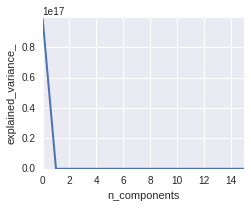

In [7]:
estimator.cv_results_

{'mean_fit_time': array([ 1.13363171,  1.33126267,  1.57173642,  0.06460166,  0.11447104,
         0.07637501,  0.02419416,  0.0372657 ,  0.03928272,  0.07716775,
         0.10341573,  0.18675931,  0.86450362,  1.53046759,  1.67597365,
         0.06485335,  0.08571259,  0.07520405,  0.02621667,  0.03569531,
         0.04265634,  0.09996661,  0.12033168,  0.19553073,  0.9095126 ,
         1.26916663,  1.50300701,  0.06849567,  0.09306534,  0.08328168,
         0.02967238,  0.04749926,  0.04508734,  0.0914766 ,  0.10709031,
         0.173383  ]),
 'mean_score_time': array([ 0.00065295,  0.00065804,  0.00075793,  0.00057236,  0.00084503,
         0.00074967,  0.00062974,  0.00070103,  0.00081762,  0.00061528,
         0.00067321,  0.00119178,  0.00064206,  0.00062672,  0.00074768,
         0.00060701,  0.000681  ,  0.00078591,  0.00075237,  0.00068069,
         0.00082429,  0.00073163,  0.00067337,  0.00084027,  0.00060169,
         0.0006477 ,  0.00075324,  0.00063101,  0.00068474,  0.00

In [15]:
pd.DataFrame(pca.components_,columns=X.columns)

,Intercept,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,aspect_ratio,budget,cast_total_facebook_likes,director_facebook_likes,duration,facenumber_in_poster,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_user_for_reviews,num_voted_users,title_year
0,0.0,6.158703e-07,4.122498e-07,1.861868e-07,3.739348e-12,1.000000e+00,0.000001,2.453466e-07,3.245581e-09,-1.361421e-10,1.222433e-10,3.005359e-06,4.102250e-08,5.791991e-08,2.372417e-05,1.172334e-09
1,-0.0,2.014700e-02,8.681576e-03,4.134552e-03,2.973127e-07,-2.394080e-05,0.035679,1.075947e-02,4.567515e-05,-3.856553e-07,3.524143e-06,8.748485e-02,5.344004e-04,1.836914e-03,9.952164e-01,5.563669e-06
2,-0.0,3.044229e-01,8.278524e-02,3.203335e-02,2.562708e-06,-1.042500e-06,0.438417,-2.163424e-03,1.223984e-04,9.407970e-06,2.998838e-06,8.354509e-01,3.008434e-03,1.591069e-04,-9.615447e-02,1.936205e-04
3,0.0,4.985078e-01,1.039038e-01,4.008251e-02,2.575750e-08,8.255882e-08,0.667093,7.756734e-03,-7.160618e-07,9.142119e-06,-3.345472e-06,-5.420852e-01,-1.402834e-03,-4.657174e-04,1.248983e-02,-4.435336e-05
4,0.0,6.593528e-01,-5.909469e-01,-2.810301e-01,1.234039e-06,2.138027e-07,-0.365832,-5.231903e-02,-3.496958e-05,-4.277794e-05,1.342436e-05,2.146841e-02,-3.230345e-04,-1.891060e-03,4.772002e-03,-1.150953e-05
5,0.0,3.300228e-02,-3.064034e-02,-1.040459e-02,-2.180755e-06,2.054628e-08,-0.025629,9.985163e-01,7.409864e-04,-4.539018e-05,1.674921e-05,6.205378e-03,-7.913783e-04,3.996753e-03,-1.078638e-02,-2.388906e-04
6,0.0,-1.961297e-01,-6.732913e-01,6.807274e-01,-1.138203e-06,1.503561e-09,0.211427,-1.715132e-03,-5.116579e-04,3.766206e-05,-7.932303e-05,1.061799e-03,-3.272745e-03,1.025700e-02,-6.559790e-04,-1.928598e-05
7,0.0,-4.283873e-01,-4.220107e-01,-6.739200e-01,1.040549e-05,-3.993162e-09,0.426327,4.937761e-03,9.645712e-04,-2.592849e-04,-1.650957e-04,-2.791878e-05,8.472064e-03,4.869104e-02,-2.760921e-04,1.559211e-04
8,0.0,2.434902e-02,2.646093e-02,2.610746e-02,1.462370e-04,-1.599340e-08,-0.023615,-4.231637e-03,1.165591e-02,-8.107269e-04,-4.626777e-04,-9.108129e-04,1.122760e-01,9.923219e-01,-1.752186e-03,6.985896e-04
9,0.0,-2.680369e-04,1.928329e-03,-4.884405e-03,-5.227151e-04,2.318769e-08,0.000817,-1.239935e-03,1.620013e-02,7.727561e-04,-1.456072e-03,3.226398e-03,-9.925635e-01,1.122447e-01,3.469544e-05,-4.373986e-02


In [14]:
estimator.best_params_

{'logistic__C': 1.0, 'logistic__solver': 'newton-cg', 'pca__n_components': 4}